# SCDC vs MPBP

## Module load

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/SCDC/various`


In [2]:
using SmallCouplingDynamicCavity
using Graphs, GraphRecipes
using Distributions
import PyPlot as plt 
using PyCall

In [3]:
function sort_by_infection_time(X, T, NV)
    inf_tuples = Dict()
    first_time_inf = ones(Int, NV).*(T+1)
    for i=1:NV
        t1 = 0
        t2 = 0
        inf = false
        for t=0:T
            if X[i,t+1]==1 && !inf
                t1 = t
                inf = true
            elseif X[i,t+1]==2 && inf
                t2 = t
                if !haskey(inf_tuples, i)
                    merge!(inf_tuples, Dict(i=>[(t1,t2)]))
                    first_time_inf[i] = t1
                else
                    push!(inf_tuples[i],(t1,t2))
                end
                inf = false
            else
                continue
            end
        end
        if inf
            if !haskey(inf_tuples, i)
                merge!(inf_tuples, Dict(i=>[(t1,T)]))
                first_time_inf[i] = t1
            else
                push!(inf_tuples[i],(t1,T))
            end
        end
    end
    #display(first_time_inf)
    perm = sortperm(first_time_inf)
    
    return inf_tuples, invperm(perm), perm
end

function meshgrid(x,y)
    nx=length(x)
    ny=length(y)
    X=zeros(ny,nx)
    Y=zeros(ny,nx)
    for jx=1:nx
        for ix=1:ny
            X[ix,jx]=x[jx]
            Y[ix,jx]=y[ix]
        end
    end
    return X, Y
end

meshgrid (generic function with 1 method)

## Data load

In [4]:
using JLD2

data_config = JLD2.load("test_data.jld2")
data_beliefs_mpbp = JLD2.load("beliefs_mpbp.jld2");

In [5]:
T = 20 # total time

G = data_config["G"]
obsmat = data_config["obsmat"]
config = data_config["config"]

beliefs_mpbp = data_beliefs_mpbp["b_bp"]

NV = nv(G)

obslist = []
for i in 1:NV
    for t in 0:T
        if obsmat[i, t+1] >= 0.0
            push!(obslist, (i, t))
        end
    end
end

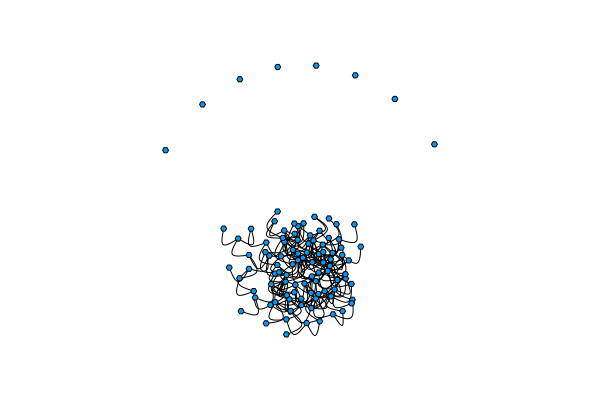

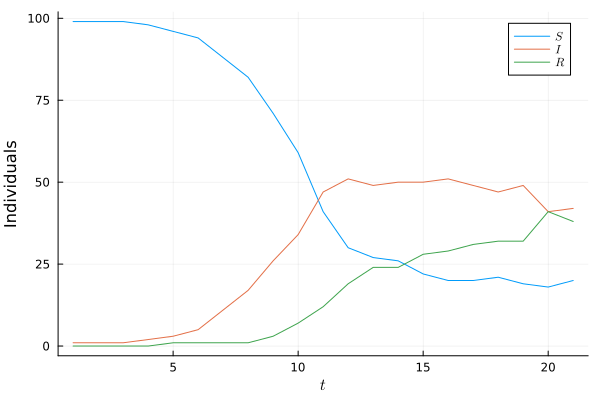

In [6]:
display(graphplot(G))

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
display(plot([nrS nrI nrR], xlabel = L"t", ylabel = "Individuals", label = [L"S" L"I" L"R"]))

## - SIRS:

### System parameter definition

In [8]:
# define the constants
γ = 1/NV # Patient zero probability
λ₀ = 0.4 # Infection rate
r₀ = 0.15 # Recovery rate
σ₀ = 0.15 # Immunity rate
ε_autoinf = 1e-10 # Self-infection rate

# define the observation probability
function obsprob(Ob, x)
    if Ob == -1
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SIRS(ε_autoinf, r₀, σ₀, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ), obsmat)

# sorting
inf_tuple, invperm_sort, perm_sort = sort_by_infection_time(config, T, NV);

### Inference -- autoinfection, $\mu$ cutoff

In [9]:
# computational constants
epsconv = 5e-15 # convergence threshold
maxiter = Int(5e2) # max number of iterations
damp = 0.0 # damping factor
μ_cutoff = -1.0 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

marg_prob_sorted_SCDC = zeros(NV, T+1, 3)
for inode in nodes
#    marg_prob_sorted[inode.i,:,:] .= inode.marg.m'
    marg_prob_sorted_SCDC[invperm_sort[inode.i],:,:] .= inode.marg.m'
end

marg_prob_sorted_MPBP = zeros(NV, T+1, 3)
for i in 1:NV
    marg_prob_sorted_MPBP[invperm_sort[i],:,:] .= [beliefs_mpbp[i][t][2] for t in 1:T+1]
end

 #marg_prob_sorted = marg_prob_sorted[perm_sort,:,:];

i = 1 ε = 1.0
i = 2 ε = 0.9136379596292731
i = 3 ε = 0.7579066969974655
i = 4 ε = 0.6036285357103522
i = 5 ε = 0.5066608586886328
i = 6 ε = 0.4764400157705154
i = 7 ε = 0.49240379819532976
i = 8 ε = 0.5915163256830795
i = 9 ε = 0.36087936084937894
i = 10 ε = 0.2575817114199474
i = 11 ε = 0.38635053887493637
i = 12 ε = 0.27836133653485445
i = 13 ε = 0.2585625550719311
i = 14 ε = 0.2562054665320801
i = 15 ε = 0.19592375166132164
i = 16 ε = 0.14077694745276675
i = 17 ε = 0.04774552065832527
i = 18 ε = 0.05509566179563091
i = 19 ε = 0.025735420614707794
i = 20 ε = 0.01989121411481054
i = 21 ε = 0.020930671060022887
i = 22 ε = 0.016059672237806355
i = 23 ε = 0.007170781199138887
i = 24 ε = 0.004719868393046056
i = 25 ε = 0.00730703459735349
i = 26 ε = 0.005038018322368332
i = 27 ε = 0.0026718162269162016
i = 28 ε = 0.00325748257175007
i = 29 ε = 0.0018207117940108875
i = 30 ε = 0.0010728887889339123
i = 31 ε = 0.0005532265364551203
i = 32 ε = 0.0005159487149625219
i = 33 ε = 0.0004361340252

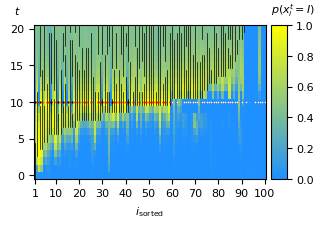

In [13]:
cols = ["white", "red", "black"]

# Custom color gradient
color1 = "dodgerblue"  # Starting color
color2 = "yellow"      # Ending color
# Create a colormap using LinearSegmentedColormap
cm = plt.matplotlib.colors.LinearSegmentedColormap.from_list("custom_cmap", [color1, color2])

# Create subplots
fig, ax = plt.subplots(figsize=(3.4, 2))  # 2 vertical subplots
rcParams = PyDict(plt.matplotlib["rcParams"])
rcParams["font.size"] = 8  #9 18

## Heatmap ##
# Define axes
x_edges = .5:(NV + .5)  # Edges for x-axis (0.5 to NV + 0.5)
y_edges = -.5:T+.5  # Edges for y-axis (0 to T)
# Create X, Y coordinate matrices
X, Y = meshgrid(x_edges, y_edges)
# Plot heatmap
p = ax.pcolor(X, Y, marg_prob_sorted_SCDC[:,:,2]', cmap=cm, vmin=0, vmax=1, edgecolors="none")
ax.set_ylim(-.5, T+.5)
ax.set_xlim(.5, NV+.5)
ax.set_ylabel(L"t", rotation="horizontal", labelpad=-5, y=1.06) 
ax.set_xlabel(L"$i_\text{sorted}$")
ax.set_xticks(vcat([1],collect(10:10:NV)))
ax.set_yticks(0:5:T)
#ax.grid(alpha=.2)

# Plot infection times
for (i, inf_time_list) in inf_tuple
    for inf_time in inf_time_list
        ax.plot([invperm_sort[i],invperm_sort[i]], [inf_time[1]-.4, inf_time[2]+.4], c="black", lw=.5, zorder=1)
    end
end

# Plot observations
for (i, t) in obslist
    ax.scatter(invperm_sort[i], t, s=2, c=cols[ceil(Int, config[i, t + 1]) + 1], edgecolor="black", linewidths=.1, zorder=2)
end

# Add colorbars with adjusted width and position
cbar = fig.colorbar(p, ax=ax, orientation="vertical", fraction=0.1, pad=.02, aspect=10, drawedges=false)
cbar.set_label(L"$p(x_i^t=I)$", y=1.15, rotation="horizontal", labelpad=-15)

# Show the plot
plt.display_figs()

fig.savefig("I_SCDC_autoinf_ER_k3.png", format="png", bbox_inches="tight", dpi=2000)